# install dependencies

In [ ]:
!pip install -U torch==1.12.1

In [ ]:
!pip install -U torchtext==0.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.7 MB/s eta 0:00:00
  Using cached torch-1.12.1-cp310-cp310-manylinux1_x86_64.whl (776.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.18.0
    Uninstalling torchtext-0.18.0:
      Successfully uninstalled torchtext-0.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.12.1 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.12.1 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 1.12.1 which is incompatible.


In [ ]:
!pip install pytorch-lifestream

# get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -R /content/drive/MyDrive/ecg_data/ ecg_data/

# train coles model

In [ ]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb


from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pad_sequence
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from ptls.frames.coles.sampling_strategies.pair_selector import PairSelector
from ptls.frames.coles.metric import outer_pairwise_distance, BatchRecallTopK

In [ ]:
data_path = 'ecg_data'

In [ ]:
signals = np.load(os.path.join(data_path, 'signals.npy'))

In [ ]:
signals.shape

(21837, 1000, 12)

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss

    "Signature verification using a siamese time delay neural network", NIPS 1993
    https://papers.nips.cc/paper/769-signature-verification-using-a-siamese-time-delay-neural-network.pdf
    """

    def __init__(self, margin, sampling_strategy):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = sampling_strategy

    def forward(self, embeddings, target):

        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        positive_loss = F.pairwise_distance(embeddings[positive_pairs[:, 0]], embeddings[positive_pairs[:, 1]]).pow(2)

        negative_loss = F.relu(
            self.margin - F.pairwise_distance(embeddings[negative_pairs[:, 0]], embeddings[negative_pairs[:, 1]])
        ).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)

        return loss.sum()

In [ ]:
class HardNegativePairSelector(PairSelector):
    """
    Generates all possible possitive pairs given labels and
         neg_count hardest negative example for each example
    """

    def __init__(self, neg_count=1):
        super(HardNegativePairSelector, self).__init__()
        self.neg_count = neg_count

    def get_pairs(self, embeddings, labels):
        # construct matrix x, such as x_ij == 0 <==> labels[i] == labels[j]
        n = labels.size(0)
        x = labels.expand(n, n) - labels.expand(n, n).t()

        # positive pairs
        positive_pairs = torch.triu((x == 0).int(), diagonal=1).nonzero(as_tuple=False)

        # hard negative minning
        mat_distances = outer_pairwise_distance(embeddings.detach())  # pairwise_distance

        upper_bound = int((2 * n) ** 0.5) + 1
        mat_distances = ((upper_bound - mat_distances) * (x != 0).type(
            mat_distances.dtype))  # filter: get only negative pairs

        values, indices = mat_distances.topk(k=self.neg_count, dim=0, largest=True)
        negative_pairs = torch.stack([
            torch.arange(0, n, dtype=indices.dtype, device=indices.device).repeat(self.neg_count),
            torch.cat(indices.unbind(dim=0))
        ]).t()

        return positive_pairs, negative_pairs

In [ ]:
TIME_SECTION = 10

TRX_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 2

VAL_SIZE = 0.05
TEST_SIZE = 0.20
BATCH_SIZE = 64
NUM_EPOCHS = 75

DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'

BEST_MODEL_PATH = 'best_model.pth'

In [ ]:
class SampleSlices:
    def __init__(self, split_count, cnt_min, cnt_max, short_seq_crop_rate=1.0, is_sorted=False):
        self.split_count = split_count
        self.cnt_min = cnt_min
        self.cnt_max = cnt_max
        self.short_seq_crop_rate = short_seq_crop_rate
        self.is_sorted = is_sorted

    def split(self, dates):
        date_len = dates.shape[0]
        date_range = np.arange(date_len)

        if date_len <= self.cnt_min and self.short_seq_crop_rate >= 1.0:
            return [date_range for _ in range(self.split_count)]

        if int(date_len * self.short_seq_crop_rate) <= self.cnt_min and self.short_seq_crop_rate < 1.0:
            cnt_min = int(date_len * self.short_seq_crop_rate)
        else:
            cnt_min = self.cnt_min

        cnt_max = self.cnt_max if date_len > self.cnt_max else date_len

        lengths = np.random.randint(cnt_min, cnt_max+1, self.split_count)
        available_start_pos = (date_len - lengths).clip(0, None)
        start_pos = (np.random.rand(self.split_count) * (available_start_pos + 1 - 1e-9)).astype(int)
        if not self.is_sorted:
            return [date_range[s:s + l] for s, l in zip(start_pos, lengths)]

        ix_sort = np.argsort(start_pos)
        return [date_range[s:s + l] for s, l in zip(start_pos[ix_sort], lengths[ix_sort])]

In [ ]:
def get_batch_splits(batch):
    labels = []
    seqs = []

    for seq_num, seq in enumerate(batch):
        cur_inds = sampler.split(seq)
        cur_seqs = [seq[ind] for ind in cur_inds]
        cur_seqs.append(torch.zeros(sampler.cnt_max, cur_seqs[0].shape[1])) ## добавить оригинальную последовательность
        cur_seqs = pad_sequence(cur_seqs, batch_first=True)[:sampler.split_count]
        seqs.append(cur_seqs)

        cur_labels = torch.tensor([seq_num]*sampler.split_count)
        labels.append(cur_labels)
    seqs = torch.vstack(seqs)
    labels = torch.hstack(labels)
    return seqs, labels

In [ ]:
sampler = SampleSlices(
    split_count=5,
    cnt_min=25,
    cnt_max=75,
)

In [ ]:
trx_encoder = nn.Sequential(
          nn.Linear(TIME_SECTION*12, TRX_SIZE)
)

In [ ]:
seq_encoder = torch.nn.LSTM(
    TRX_SIZE,
    HIDDEN_SIZE,
    NUM_LAYERS,
    batch_first=True
)

In [ ]:
model = nn.Sequential(
    trx_encoder,
    seq_encoder
)

model = model.to(DEVICE)

In [ ]:
criterion = ContrastiveLoss(
    margin=0.5,
    sampling_strategy=HardNegativePairSelector(),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

val_metric = BatchRecallTopK(sampler.split_count - 1)

In [ ]:
def train_one_batch(batch, model, criterion, optimizer, train_losses, device):
    optimizer.zero_grad()
    seqs, labels = get_batch_splits(batch)
    outputs, _ = model(seqs.float().to(device))
    embeddings = torch.stack([x[-1] for x in outputs])

    loss = criterion(embeddings.to(device), labels.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item()/len(seqs))
    return train_losses

In [ ]:
def validate_one_batch(batch, model, criterion, val_losses, val_outputs, val_labels, device):
    with torch.no_grad():
        seqs, labels = get_batch_splits(batch)
        outputs, _ = model(seqs.float().to(device))
        embeddings = torch.stack([x[-1] for x in outputs])
        loss = criterion(embeddings.to(device), labels.to(device))

        val_outputs.append(embeddings)
        val_labels.append(labels)
        val_losses.append(loss.item()/len(seqs))

    return val_losses, val_outputs, val_labels

In [ ]:
def train_one_epoch(model, criterion, optimizer, train_dataloader, device):
    model.train()
    train_loss = []
    for batch in tqdm(train_dataloader):
        train_loss = train_one_batch(batch, model, criterion, optimizer, train_loss, device)

    return sum(train_loss) / len(train_dataloader)

def validate_one_epoch(model, criterion, val_metric, val_dataloader, device):
    val_loss = []
    val_outputs = []
    val_labels = []
    model.eval()
    for batch_num, batch in enumerate(val_dataloader):
        cur_labels = []
        val_loss, val_outputs, cur_labels = validate_one_batch(batch, model, criterion, val_loss, val_outputs, cur_labels, device)
        val_labels += [label + batch_num*val_dataloader.batch_size for label in cur_labels]

    val_outputs = torch.vstack(val_outputs).cpu()
    val_labels = torch.hstack(val_labels).cpu()
    cur_metric = val_metric(val_outputs, val_labels)
    return sum(val_loss) / len(val_dataloader), cur_metric

In [ ]:
def train(
    model,
    criterion,
    val_metric,
    optimizer,
    train_dataloader,
    val_dataloader,
    num_epochs,
    device='cuda' if torch.cuda.is_available else 'cpu',
    best_model_path='best_model.pth',
    max_patience=5,
    visualize_training=True,
):

    train_losses = []
    val_losses = []
    val_metrics = []

    max_metric = -np.inf
    cur_patience = 0
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, criterion, optimizer, train_dataloader, device)
        val_loss, cur_metric = validate_one_epoch(model, criterion, val_metric, val_dataloader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(cur_metric)

        if cur_metric >= max_metric:
            max_metric = cur_metric
            torch.save(model.state_dict(), best_model_path)
        else:
            cur_patience += 1

        if visualize_training:
            visualize_training_step(epoch, num_epochs, train_loss, val_loss, cur_metric, train_losses, val_losses, val_metrics)

        if cur_patience >= max_patience:
            print(f'stop training, epoch: {epoch + 1}')
            break

In [ ]:
def visualize_training_step(epoch, num_epochs, train_loss, val_loss, cur_metric, train_losses, val_losses, val_metrics):
    clear_output(wait=True)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val metric: {cur_metric}')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_metrics, label='Val metric', color='red')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.title('Validation metric')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
train_data, val_data = train_test_split(signals, test_size=0.05)

In [ ]:
print(f'train data len = {len(train_data)}, val data len = {len(val_data)}')

train data len = 20745, val data len = 1092


In [ ]:
def collate_fn(batch):
    batch = torch.stack([torch.from_numpy(item).float() for item in batch])
    batch = batch.reshape((len(batch), -1, TIME_SECTION*12))
    return batch

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

Epoch 44/75, Train Loss: 0.006397553144611863, Val Loss: 0.006826852567286955, Val metric: 0.9988095164299011


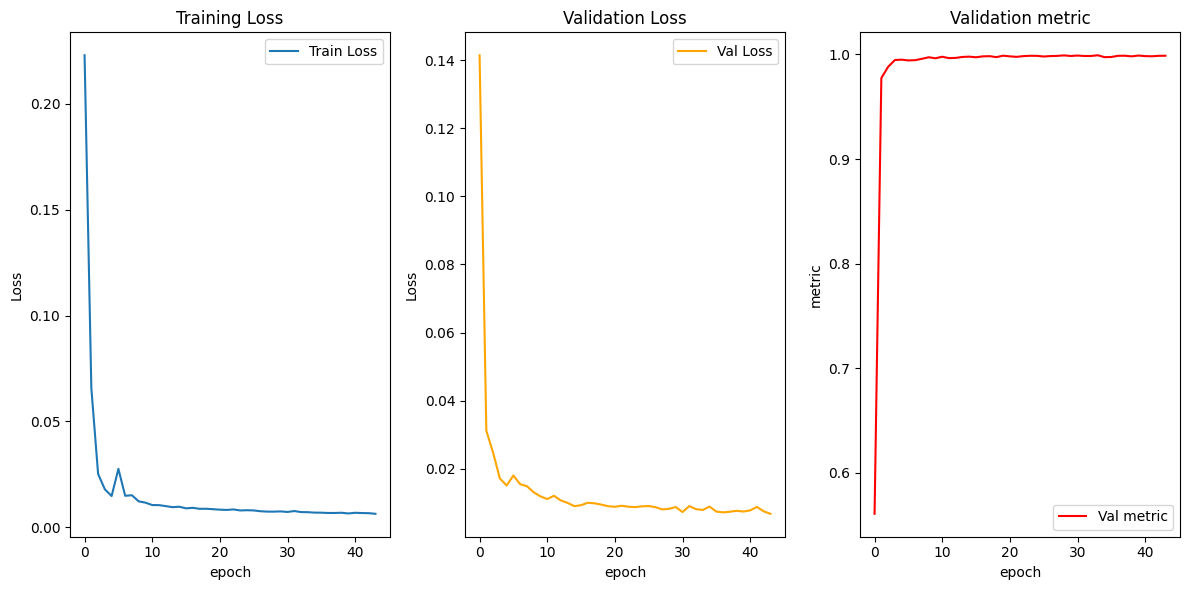

stop training, epoch: 44


In [ ]:
train(model, criterion, val_metric, optimizer, train_dataloader, val_dataloader, NUM_EPOCHS, best_model_path=BEST_MODEL_PATH, max_patience=30)

In [ ]:
def inference_embeddings(model, inference_dataloader, device):
    embeddings = []
    for batch in tqdm(inference_dataloader):
        outputs, _ = model(batch.float().to(device))
        cur_embeddings = torch.stack([x[-1] for x in outputs])
        embeddings.append(cur_embeddings)

    embeddings = torch.vstack(embeddings)
    return embeddings

In [ ]:
inference_dataloader = torch.utils.data.DataLoader(signals, batch_size=10, shuffle=False, collate_fn=collate_fn)

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model = model.to(DEVICE)

In [ ]:
embeddings = inference_embeddings(model, inference_dataloader, DEVICE)

100%|██████████| 2184/2184 [00:09<00:00, 240.50it/s]


In [ ]:
embeddings = embeddings.detach().cpu().numpy()

In [ ]:
np.save(os.path.join(data_path, 'embeddings.npy'), embeddings)

In [ ]:
def cross_validation(embeddings, target, folds):
    auc_scores = [0 for _ in range(folds.n_splits)]
    accuracy_scores = [0 for _ in range(folds.n_splits)]
    for fold_, (train_index, val_index) in tqdm(enumerate(folds.split(embeddings, target))):

        X_train, y_train = embeddings[train_index], target[train_index]
        clf = lgb.LGBMClassifier(n_estimators=2500, early_stop_rounds=100)
        clf.fit(X_train, y_train)


        X_val, y_val = embeddings[val_index], target[val_index]


        y_pred=clf.predict(X_val)
        probs=clf.predict_proba(X_val)[:, 1]


        accuracy = accuracy_score(y_pred, y_val)
        roc_auc = roc_auc_score(y_val, probs)

        auc_scores[fold_] = roc_auc
        accuracy_scores[fold_] = accuracy


    print("CV score(auc): {:<8.5f}, (std: {:<8.5f})".format(np.mean(auc_scores), np.std(auc_scores)))
    print("CV score(accuracy): {:<8.5f}, (std: {:<8.5f})".format(np.mean(accuracy_scores), np.std(auc_scores)))
    return (auc_scores, accuracy_scores)

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
target = np.load(os.path.join(data_path, 'target.npy'))

In [ ]:
scores = cross_validation(embeddings, target, folds)

0it [00:00, ?it/s]

[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Info] Number of positive: 3244, number of negative: 14225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 17469, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.185700 -> initscore=-1.478194
[LightGBM] [Info] Start training from score -1.478194
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Warning] Unknown parameter: early_stop_rounds
[LightGBM] [Info] Number of positive: 3244, number of negative: 14225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

In [ ]:
print(scores)

([0.7213462487091499, 0.707198289474186, 0.7270645192162324, 0.7253886729017072, 0.7192213642838418], [0.8262362637362637, 0.8282967032967034, 0.8282573849324479, 0.8280283947790245, 0.830547286466682])


In [ ]:
accuracy=accuracy_score(y_pred, y_test)
roc_auc = roc_auc_score(y_test, probs)

print('COLES model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print(f'COLES model roc auc score: {roc_auc}')

COLES model accuracy score: 0.8329
COLES model roc auc score: 0.7322524541479913


In [ ]:
clf = lgb.LGBMClassifier()

clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3235, number of negative: 14234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65247
[LightGBM] [Info] Number of data points in the train set: 17469, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.185185 -> initscore=-1.481605
[LightGBM] [Info] Start training from score -1.481605


LGBMClassifier()

In [ ]:
y_pred=clf.predict(X_test)
probs=clf.predict_proba(X_test)[:, 1]

In [ ]:
accuracy=accuracy_score(y_pred, y_test)
roc_auc = roc_auc_score(y_test, probs)

print('COLES model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print(f'COLES model roc auc score: {roc_auc}')

COLES model accuracy score: 0.8246
COLES model roc auc score: 0.742102730497429
